In [192]:
# IMPORT MODULES
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

In [122]:
# IMPORT DATA
amazon_reviews = pd.read_csv('Downloads/amazon_reviews_us_Grocery_v1_00.tsv', sep='\t', error_bad_lines = False)

amazon_reviews.head()

b'Skipping line 1925: expected 15 fields, saw 22\nSkipping line 1977: expected 15 fields, saw 22\nSkipping line 35265: expected 15 fields, saw 22\nSkipping line 53357: expected 15 fields, saw 22\n'
b'Skipping line 68361: expected 15 fields, saw 22\nSkipping line 70922: expected 15 fields, saw 22\nSkipping line 73503: expected 15 fields, saw 22\nSkipping line 85612: expected 15 fields, saw 22\nSkipping line 102322: expected 15 fields, saw 22\n'
b'Skipping line 158341: expected 15 fields, saw 22\nSkipping line 162872: expected 15 fields, saw 22\nSkipping line 195697: expected 15 fields, saw 22\n'
b'Skipping line 202916: expected 15 fields, saw 22\nSkipping line 203949: expected 15 fields, saw 22\nSkipping line 250853: expected 15 fields, saw 22\n'
b'Skipping line 265820: expected 15 fields, saw 22\nSkipping line 304569: expected 15 fields, saw 22\nSkipping line 313136: expected 15 fields, saw 22\nSkipping line 313160: expected 15 fields, saw 22\nSkipping line 316345: expected 15 fields, 

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nu...",2015-08-31
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and ...",2015-08-31
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend l...,2015-08-31
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great sec...,2015-08-31
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31


In [211]:
# GENERAL INFO (RAW DATA)

# TOTAL DATA POINTS
print(len(amazon_reviews))

# COLUMN NAMES & TYPES
print(amazon_reviews.dtypes)

# Categorisation - looking at tea category
amazon_reviews['organic'] = np.where(amazon_reviews.product_title.str.contains('Organic'), 'organic', 'non-organic')
amazon_reviews['tea'] = np.where(amazon_reviews.product_title.str.contains(' tea'), 'tea', 'non-tea')
amazon_reviews = amazon_reviews[~amazon_reviews['product_title'].str.contains('coffee')]

amazon_reviews = amazon_reviews[amazon_reviews['tea'] == 'tea']

amazon_reviews.groupby('organic').product_title.value_counts()

amazon_reviews['review_body'] = amazon_reviews['review_body'].astype(str)

# amazon_reviews['parsed_review'] =  amazon_reviews['review_body'].head(5000).apply(word_tokenize)
amazon_reviews2 = amazon_reviews[:200000]

4795
marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating           object
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
organic               object
tea                   object
dtype: object


In [188]:
#lowecase
amazon_reviews2['review_body'] = amazon_reviews2['review_body'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove punctuation
amazon_reviews2['review_body'] = amazon_reviews2['review_body'].str.replace('[^\w\s]','')

#stemming
st = PorterStemmer()
amazon_reviews2['review_body'] = amazon_reviews2['review_body'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

#remove commonly occuring words
stop  = stopwords.words('english')
stop.extend(['great', 'good', 'like', 'product', 'love', 'br', 'would', 'nice', 'really', 'ive', 'dont', 'im', 'much', 'also', 'tea', 'green', 'one', 'drink', 'get', 'cup', 'tri', 'buy', 'use'])

amazon_reviews2['review_body'] = amazon_reviews2['review_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [189]:
# frequency of words in organic and non-organic
word_freq_org = amazon_reviews2[amazon_reviews2['organic'].isin(['organic'])].review_body.str.split(expand=True).stack().value_counts() / amazon_reviews2[amazon_reviews2['organic'].isin(['organic'])].review_body.str.split(expand=True).stack().value_counts().sum()
word_freq_non_org = amazon_reviews2[amazon_reviews2['organic'].isin(['non-organic'])].review_body.str.split(expand=True).stack().value_counts() / amazon_reviews2[amazon_reviews2['organic'].isin(['non-organic'])].review_body.str.split(expand=True).stack().value_counts().sum()

# print(word_freq_org.head(20))
# print(word_freq_non_org.head(20))

In [204]:
# combine 2 freq tables
word_freq_org_df = word_freq_org.reset_index(name='freq')
word_freq_non_org_df = word_freq_non_org.reset_index(name='freq')

word_req_df = word_freq_org_df.merge(word_freq_non_org_df, how = 'outer', on = 'index', suffixes = ('_org', '_nonorg'))
word_req_df = word_req_df.rename(columns = {'index':'word'})
word_req_df['freq_org'] = word_req_df['freq_org'] * 100
word_req_df['freq_nonorg'] = word_req_df['freq_nonorg'] * 100
# print(word_req_df[:10])

In [205]:
# change 'word' to index of DataFrame
word_req_df.set_index('word', inplace=True)
print(word_req_df[:10])

           freq_org  freq_nonorg
word                            
tast       2.220888     1.985847
flavor     1.860744     1.371642
bag        1.180472     1.122804
organ      0.840336     0.112887
sweet      0.620248     0.217278
recommend  0.620248     0.432128
even       0.540216     0.366580
well       0.540216     0.416348
price      0.520208     0.619060
delici     0.500200     0.301033


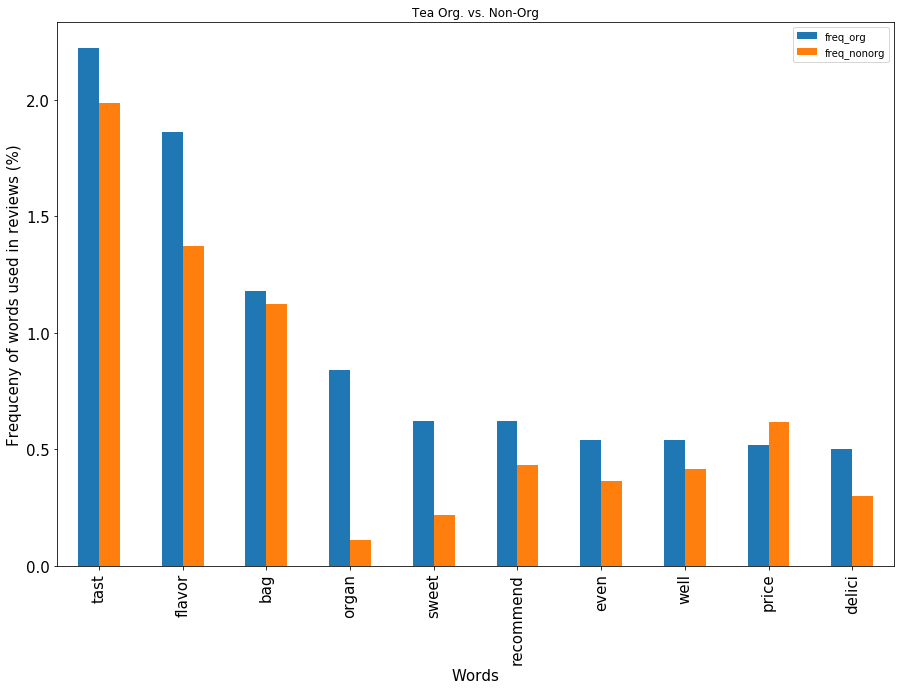

In [232]:
# plot on bar chart
word_req_df2 = word_req_df[:10]

tea_plot = word_req_df2[['freq_org', 'freq_nonorg']].plot(kind='bar', title ="Tea Org. vs. Non-Org", figsize=(15, 10), legend=True, fontsize=15)
tea_plot.set_xlabel("Words", fontsize=15)
tea_plot.set_ylabel("Frequceny of words used in reviews (%)", fontsize=15)
plt.show()

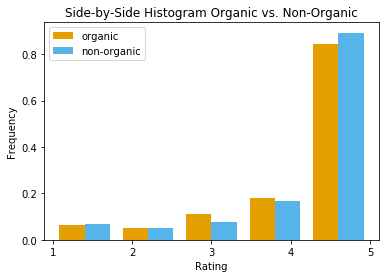

In [283]:
# Make a separate list for each type
#amazon_reviews2.groupby('tea').star_rating.hist()

amazon_reviews2['star_rating'] = pd.to_numeric(amazon_reviews2['star_rating'], errors='coerce')
amazon_reviews2 = amazon_reviews2.dropna(subset=['star_rating'])

# amazon_reviews2['star_rating'] = amazon_reviews2['star_rating'].astype(float)
amazon_reviews2['star_rating'] = amazon_reviews2['star_rating'].astype(int)

x1 = list(amazon_reviews2[amazon_reviews2['organic'] == 'organic']['star_rating'])
x2 = list(amazon_reviews2[amazon_reviews2['organic'] == 'non-organic']['star_rating'])

# Assign colors for each type of tea
colors = ['#E69F00', '#56B4E9']
names = ['organic', 'non-organic'] 

# Make the histogram using a list of lists
plt.hist([x1, x2], density = True, color = colors, label = names, bins = 5)

# Plot formatting
plt.legend()
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Side-by-Side Histogram Organic vs. Non-Organic')
plt.xticks(np.arange(1,6,1))

plt.show()